# Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from fastai.vision import *
from fastai.vision.models.xresnet import *

# for datablock API
from fastai.vision.image import _resolve_tfms, _get_crop_target, _round_multiple, _get_resize_target, _affine_grid, _grid_sample, _affine_mult

# for XResNet
#from fastai.vision.models.xresnet import act_fn, init_cnn, conv, noop, conv_layer, ResBlock, filt_sz


In [3]:
from fastai.callbacks import CSVLogger, ReduceLROnPlateauCallback, SaveModelCallback

In [4]:
#from efficientnet_pytorch import *

In [5]:
from nb_new_data_augmentation_adacos_celltype_plategroup_exp import *

In [6]:
import pdb

In [7]:
__version__

'1.0.55'

# 6D image with celltype

In [8]:
class Image6Dct(Image):
    "Support applying transforms to image data in `px`."
    def __init__(self, px:Tensor, ctint, pgint, expint): # ct
        self._px = px
        self._logit_px=None
        #self.ct = ct
        self.ctint = ctint
        self.pgint = pgint
        self.expint = expint
        self._flow=None
        self._affine_mat=None
        self.sample_kwargs = {}
    
    def _repr_image_format(self, format_str):
        with BytesIO() as str_buffer:
            #plt.imsave(str_buffer, image2np(self.px[:3]), format=format_str)
            plt.imsave(str_buffer, 
                       np.concatenate((image2np(self.px[:3]), 
                                       image2np(self.px[3:])), axis=1),
                       format=format_str)
            return str_buffer.getvalue()
        
    def clone(self):
        "Mimic the behavior of torch.clone for `Image` objects."
        return self.__class__(self.px.clone(), self.ctint.clone(), self.pgint.clone(), self.expint.clone()) # self.ct.clone(), 

    @property
    def data(self)->TensorImage:
        "Return this images pixels as a tensor."
        return self.px, self.ctint, self.pgint, self.expint
    

In [9]:
def open_image_6Dct(fn:PathOrStr, div:bool=True, convert_mode:str='L', cls:type=Image6Dct,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        
        x = []
        for i in range(6):
            c = PIL.Image.open(fn+'_w'+str(i+1)+'.png').convert(convert_mode)
            if after_open: c = after_open(c)
            c = np.asarray(c)
            c = torch.from_numpy(c.astype(np.float32, copy=False))
            x.append(c)
    ct = fn.split('/')[1].split('-')[0] # get cell type
    ctint = torch.tensor(ct2int[ct])
    pgint = torch.tensor(fn2pgint[fn])
    exp = fn.split('/')[1] # get experiment
    expint = torch.tensor(exp2int[exp])
    x = torch.stack(x)
    if div: x.div_(255)
    return cls(x, ctint, pgint, expint)

In [10]:
# number experiments so that cell types do not overlap
# and the valid and test dataset do have a embedding they can use!
exp2int = {'HEPG2-01': 0,
           'HEPG2-02': 1,
           'HEPG2-03': 2,
           'HEPG2-04': 3,
           'HEPG2-05': 4,
           # valid
           'HEPG2-06': 0,
           'HEPG2-07': 1,
           # test
           'HEPG2-08': 0,
           'HEPG2-09': 1,
           'HEPG2-10': 2,
           'HEPG2-11': 3,           
             
           # train
           'HUVEC-01': 5,
           'HUVEC-02': 6,
           'HUVEC-03': 7,
           'HUVEC-04': 8,
           'HUVEC-05': 9,
           'HUVEC-06': 10,
           'HUVEC-07': 11, 
           'HUVEC-08': 12,
           'HUVEC-09': 13,
           'HUVEC-10': 14,
           'HUVEC-11': 15,
           'HUVEC-12': 16,
           'HUVEC-13': 17,
           'HUVEC-14': 18, 
           # valid
           'HUVEC-15': 5,
           'HUVEC-16': 6, 
           # test
           'HUVEC-17': 5,
           'HUVEC-18': 6,
           'HUVEC-19': 7,
           'HUVEC-20': 8,
           'HUVEC-21': 9,
           'HUVEC-22': 10,
           'HUVEC-23': 11,
           'HUVEC-24': 12,
             
           # train
           'RPE-01': 19,
           'RPE-02': 20,
           'RPE-03': 21,
           'RPE-04': 22,
           'RPE-05': 23,
           # valid
           'RPE-06': 19,
           'RPE-07': 20,
           # test
           'RPE-08': 19,
           'RPE-09': 20,
           'RPE-10': 21,
           'RPE-11': 22,
             
           # train
           'U2OS-01': 24,
           'U2OS-02': 25,
           # valid
           'U2OS-03': 24,
           # test
           'U2OS-04': 24,
           'U2OS-05': 25
          }

In [11]:
exp2int

{'HEPG2-01': 0,
 'HEPG2-02': 1,
 'HEPG2-03': 2,
 'HEPG2-04': 3,
 'HEPG2-05': 4,
 'HEPG2-06': 0,
 'HEPG2-07': 1,
 'HEPG2-08': 0,
 'HEPG2-09': 1,
 'HEPG2-10': 2,
 'HEPG2-11': 3,
 'HUVEC-01': 5,
 'HUVEC-02': 6,
 'HUVEC-03': 7,
 'HUVEC-04': 8,
 'HUVEC-05': 9,
 'HUVEC-06': 10,
 'HUVEC-07': 11,
 'HUVEC-08': 12,
 'HUVEC-09': 13,
 'HUVEC-10': 14,
 'HUVEC-11': 15,
 'HUVEC-12': 16,
 'HUVEC-13': 17,
 'HUVEC-14': 18,
 'HUVEC-15': 5,
 'HUVEC-16': 6,
 'HUVEC-17': 5,
 'HUVEC-18': 6,
 'HUVEC-19': 7,
 'HUVEC-20': 8,
 'HUVEC-21': 9,
 'HUVEC-22': 10,
 'HUVEC-23': 11,
 'HUVEC-24': 12,
 'RPE-01': 19,
 'RPE-02': 20,
 'RPE-03': 21,
 'RPE-04': 22,
 'RPE-05': 23,
 'RPE-06': 19,
 'RPE-07': 20,
 'RPE-08': 19,
 'RPE-09': 20,
 'RPE-10': 21,
 'RPE-11': 22,
 'U2OS-01': 24,
 'U2OS-02': 25,
 'U2OS-03': 24,
 'U2OS-04': 24,
 'U2OS-05': 25}

In [12]:
df_full_plate_pattern = pd.read_csv('full_dataset_v2_path_plate_groups_only_20190812.csv', index_col=0)

In [13]:
df_full_plate_pattern.head()

,path,plate_pattern
0,train/HEPG2-01/Plate1/B03_s1,0
1,train/HEPG2-01/Plate1/B04_s1,0
2,train/HEPG2-01/Plate1/B05_s1,0
3,train/HEPG2-01/Plate1/B06_s1,0
4,train/HEPG2-01/Plate1/B07_s1,0


In [14]:
fn2pgint = dict(zip(df_full_plate_pattern.path.values, 
                              df_full_plate_pattern.plate_pattern.values))

In [15]:
fn2pgint['train/HEPG2-01/Plate1/B03_s1']

0

In [16]:
# cell types from rcic_v10_inspect_image_data.ipynb "pixel stats"
cts = ['HEPG2', 'HUVEC', 'RPE', 'U2OS']
int2ct = {i: ct for i, ct in enumerate(cts)}
ct2int = {ct: i for i, ct in int2ct.items()}

In [17]:
print(int2ct)
print(ct2int)

{0: 'HEPG2', 1: 'HUVEC', 2: 'RPE', 3: 'U2OS'}
{'HEPG2': 0, 'HUVEC': 1, 'RPE': 2, 'U2OS': 3}


In [18]:
ct = 'train/HEPG2-01/Plate1/B03_s1'.split('/')[1].split('-')[0]; ct

'HEPG2'

In [19]:
ct2int[ct]

0

In [20]:
PATH_trunc = 'train/HEPG2-01/Plate1/B03_s1' # path is missing suffix "_w1.png"

In [21]:
img = open_image_6Dct(PATH_trunc)

In [22]:
img.px.shape

torch.Size([6, 512, 512])

In [23]:
img.ctint, img.pgint, img.expint

(tensor(0), tensor(0), tensor(0))

In [24]:
type(img.ctint), type(img.pgint), type(img.expint)

(torch.Tensor, torch.Tensor, torch.Tensor)

# Dataset setup

In [25]:
class ImageList6Dct(ImageList): #ImageList
    def __init__(self, *args, convert_mode='L', after_open:Callable=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.convert_mode,self.after_open = convert_mode,after_open
        self.copy_new.append('convert_mode')
        self.c,self.sizes = 6,{}
        
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image_6Dct(fn, convert_mode=self.convert_mode, after_open=self.after_open)

#    def show(self, img):
#        #return torch.cat((img[i][:3], img[i][3:]), dim=1)
#        show_image(img)
    
    # https://docs.fast.ai/tutorial.itemlist.html#Advanced-show-methods
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(15,10), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            #xs[i].show(ax=ax, y=ys[i], **kwargs)
            img = Image6D(torch.cat((xs[i].data[:3], xs[i].data[3:]), dim=2)) # works but not elegant?
            #img = Image6D(xs[i]) # does not work?
            img.show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

In [26]:
#def show_image(img:Image, ax:plt.Axes=None, figsize:tuple=(3,3), hide_axis:bool=True, cmap:str='binary',
#                alpha:float=None, **kwargs)->plt.Axes:
#    "Display `Image` in notebook."
#    if ax is None: fig,ax = plt.subplots(figsize=figsize)
#    pdb.set_trace()
#    #ax.imshow(image2np(img.data), cmap=cmap, alpha=alpha, **kwargs)
#    ax.imshow(np.concatenate((image2np(self.px[:3]),
#                              image2np(self.px[3:])), axis=1),
#              cmap=cmap, alpha=alpha, **kwargs)
#    if hide_axis: ax.axis('off')
#    return ax


## Full dataset

### Dataset raw files

In [27]:
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [28]:
df_train.shape

(73030, 5)

In [29]:
df_train.tail()

,path,experiment,sirna,multi,valid
36510,U2OS-03/Plate4/O19_s2,U2OS-03,103,U2OS-03 103,1
36511,U2OS-03/Plate4/O20_s2,U2OS-03,202,U2OS-03 202,1
36512,U2OS-03/Plate4/O21_s2,U2OS-03,824,U2OS-03 824,1
36513,U2OS-03/Plate4/O22_s2,U2OS-03,328,U2OS-03 328,1
36514,U2OS-03/Plate4/O23_s2,U2OS-03,509,U2OS-03 509,1


In [30]:
df_test.tail()

,path,experiment
19892,U2OS-05/Plate4/O19_s2,U2OS-05
19893,U2OS-05/Plate4/O20_s2,U2OS-05
19894,U2OS-05/Plate4/O21_s2,U2OS-05
19895,U2OS-05/Plate4/O22_s2,U2OS-05
19896,U2OS-05/Plate4/O23_s2,U2OS-05


### Color augmentation transformation

"Color Augmentation: Color variability can be increased by applying random color transformations to original training samples. We perform color augmentation by transforming every color channels Ic ← ac · Ic + bc, where ac and bc are drawn from uniform distributions ac ∼ U [0.9, 1.1] and bc ∼ U [−10, +10]." from Domain-adversarial neural networks to address the appearance variability of histopathology images

In [31]:
# from https://github.com/fastai/fastai/blob/master/fastai/vision/transform.py#L137
#def _rgb_randomize(x, channel:int=None, thresh:float=0.3):
#    "Randomize one of the channels of the input image"
#    if channel is None: channel = np.random.randint(0, x.shape[0] - 1)
#    x[channel] = torch.rand(x.shape[1:]) * np.random.uniform(0, thresh)
#    return x
#
#rgb_randomize = TfmPixel(_rgb_randomize)

In [32]:
# Scaling factor comes from byte tensor?
#10/255 = 0.0392156862745098

In [33]:
def _color_augmentation(x):
    "Randomize all channels of the input image"
    channel_count = x.shape[0] - 1
    
    # by transforming every color channels Ic ← ac · Ic + bc, 
    # where ac and bc are drawn from uniform distributions 
    # ac ∼ U [0.9, 1.1] and 
    # bc ∼ U [−10, +10].
    
    # x [0,1]
    
    for c in range(channel_count):
        #pdb.set_trace()
        #print(x.min(), x.max())
        ac = np.random.uniform(0.9, 1.1) #np.random.uniform(0.9, 1.1)
        bc = np.random.uniform(-0.1,0.1) #np.random.uniform(-10, 10)
        x[c] = x[c] * ac + bc
        
        # clipping to min 0 and max 1
        x[c] = torch.clamp(x[c], 0., 1.)
    
    return x

color_augmentation = TfmPixel(_color_augmentation)

### Transforms setup

In [34]:
# PRE-TRAINING
sz, bs = 128, 8*10 #20 # 7576MiB /  7952MiB INCREASE?
#sz, bs = 256, 8*5 # 7341MiB /  7952MiB
#sz, bs = 512, 8 #



In [35]:
sz, bs

(128, 80)

In [36]:
# cutout params
#int(sz*0.1), int(sz*0.5)

In [37]:
# normal tfms
#tfms = get_transforms()

In [38]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [39]:
# extended tfms
#tfms = get_transforms(do_flip=True, flip_vert=True, 
#                      max_rotate=90.0, max_zoom=1.1, 
#                      max_lighting=0.2, max_warp=0.2, 
#                      p_affine=0.75, p_lighting=0.75, 
#                      xtra_tfms=[color_augmentation(), 
#                                 cutout(n_holes=(1,4), length=(int(sz*0.1), int(sz*0.5)), p=.5)])

In [40]:
#tfms = [[crop(size=sz, row_pct=(0,1), col_pct=(0,1))], []]

In [41]:
#tfms

In [42]:
# change "crop_pad" from get_transforms to "crop"
# CENTER for FIXED cropping
tfms[0][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])
tfms[1][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])

In [43]:
# train crop
tfms[0][0].kwargs['row_pct'], tfms[0][0].kwargs['col_pct']

([0.5, 0.5], [0.5, 0.5])

In [44]:
# valid crop
tfms[1][0].kwargs['row_pct'], tfms[1][0].kwargs['col_pct']

([0.5, 0.5], [0.5, 0.5])

In [45]:
#tfms

### Dataset definition

In [46]:
# VALID SPLIT (incl. tfms)
data = (ImageList6Dct.from_df(df_train, path='train')
        .split_from_df(col=-1) # split_by_rand_pct()
        .label_from_df(cols=-3)
        .add_test(ImageList6Dct.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [47]:
# VALID SPLIT (incl. tfms)
#data = (ImageList6Dct.from_df(df_train, path='train')
#        .split_none() # !!!
#        .label_from_df(cols=-3)
#        .add_test(ImageList6Dct.from_df(df_test, path='test'))
#        .transform(tfms, size=sz) # remove size so we get the crop size!
#        .databunch(bs=bs))

In [48]:
# VALID SPLIT PREDICTION (NO tfms)
#data = (ImageList6D.from_df(df_train, path='train')
#        .split_from_df(col=-1) 
#        .label_from_df(cols=-3) # label_delim=' ' for MultiCategoryList !
#        .add_test(ImageList6D.from_df(df_test, path='test'))
#        .transform(size=sz) # !!!
#        .databunch(bs=bs))

In [49]:
# FULL DATASET PREDICTION (NO tfms)
#data = (ImageList6D.from_df(df_train, path='train')
#        .split_none() # !!!
#        .label_from_df(cols=-3)
#        .add_test(ImageList6D.from_df(df_test, path='test'))
#        .transform(size=sz)
#        .databunch(bs=bs))

In [50]:
data

ImageDataBunch;

Train: LabelList (57554 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: CategoryList
513,840,1020,254,144
Path: train;

Valid: LabelList (15476 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: CategoryList
352,361,503,505,70
Path: train;

Test: LabelList (39794 items)
x: ImageList6Dct
Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128),Image6Dct (6, 128, 128)
y: EmptyLabelList
,,,,
Path: train

In [51]:
### CHANGED LINE 65 to:
# nano ~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py

```
~/anaconda3/envs/fastai/lib/python3.6/site-packages/fastai/vision/data.py in _normalize_batch(b, mean, std, do_x, do_y)
     64     "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
     65     x,y = b
---> 66     mean,std = mean.to(x.device),std.to(x.device)
     67     if do_x: x = normalize(x,mean,std)
     68     if do_y and len(y.shape) == 4: y = normalize(y,mean,std)

AttributeError: 'list' object has no attribute 'device'
```
CHANGED TO:
```
def _normalize_batch(b:Tuple[Tensor,Tensor], mean:FloatTensor, std:FloatTensor, do_x:bool$
    "`b` = `x`,`y` - normalize `x` array of imgs and `do_y` optionally `y`."
    (x,cint,pgint,expint),y = b
    mean,std = mean.to(x.device),std.to(x.device)
    if do_x: x = normalize(x,mean,std)
    if do_y and len(y.shape) == 4: y = normalize(y,mean,std)
    return (x,cint,pgint,expint),y
```

In [52]:
#data.batch_stats() # DOES NOT WORK?

In [53]:
# From https://github.com/recursionpharma/rxrx1-utils/blob/master/rxrx/main.py
# The mean and stds for each of the channels
GLOBAL_PIXEL_STATS = (np.array([6.74696984, 14.74640167, 10.51260864,
                                10.45369445,  5.49959796, 9.81545561]),
                       np.array([7.95876312, 12.17305868, 5.86172946,
                                 7.83451711, 4.701167, 5.43130431]))

stats_mean = torch.tensor(GLOBAL_PIXEL_STATS[0]/255).float()
stats_var = torch.tensor(GLOBAL_PIXEL_STATS[1]/255).float()

In [54]:
#stats_mean, stats_var

In [55]:
data.normalize([stats_mean, stats_var]);

In [56]:
#data.batch_stats() # DOES NOT WORK?

In [57]:
data.batch_size

80

In [58]:
#data.stats # results is copied below
#[tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
# tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]

In [59]:
#data

In [60]:
data.c, len(data.classes), data.classes[-5:]

(1108, 1108, [1103, 1104, 1105, 1106, 1107])

In [61]:
data.train_ds[0]

(Image6Dct (6, 128, 128), Category 513)

In [62]:
#data.classes

In [63]:
data.train_ds[0][1], data.train_ds[0][1].data

(Category 513, 513)

In [64]:
data.train_ds[0][0].ctint, data.train_ds[0][0].pgint, data.train_ds[0][0].expint

(tensor(0), tensor(0), tensor(0))

In [65]:
len(data.train_ds[0][0].data)

4

In [66]:
data.train_ds[0][0].data[0].shape, data.train_ds[0][0].data[1].shape, data.train_ds[0][0].data[2].shape

(torch.Size([6, 128, 128]), torch.Size([]), torch.Size([]))

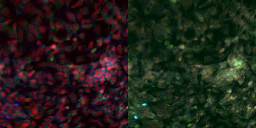

In [67]:
data.train_ds[0][0]

In [68]:
#data.train_ds[0][0].apply_tfms(crop(size=300, row_pct=(0,1), col_pct=(0,1)))

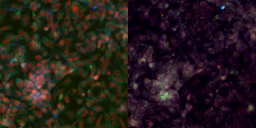

In [69]:
### ORIGINAL 512px NO TFMS
data.train_ds[0][0]

# Model setup

## EfficientNet

In [70]:
# 3d to 6d from old/rcic_multicat_v9_resnet50-pretrained_colaug.ipynb

In [71]:
import torchvision

In [72]:
efficientnet_f = torchvision.models.densenet201(pretrained=True).features

In [73]:
efficientnet_f

Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace)
      (conv1): Conv2d(96, 128, kernel_size=(1, 1), st

In [74]:
efficientnet_f[0], type(efficientnet_f[0])

(Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 torch.nn.modules.conv.Conv2d)

In [75]:
nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [76]:
p_dict = {pn: p for pn, p in efficientnet_f[0].named_parameters()}

In [77]:
p_dict.keys()

dict_keys(['weight'])

In [78]:
p_dict['weight'].shape, p_dict['weight'].requires_grad

(torch.Size([64, 3, 7, 7]), True)

In [79]:
old_weight = p_dict['weight'].detach()

In [80]:
old_weight.shape, old_weight.requires_grad

(torch.Size([64, 3, 7, 7]), False)

In [81]:
new_weight = torch.cat((old_weight, old_weight), dim=1)

In [82]:
new_weight.shape, new_weight.requires_grad

(torch.Size([64, 6, 7, 7]), False)

In [83]:
def show_input_stage_weights(weight=None, nrows=2, ncols=3):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols)
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            if nrows > 1:
                ax[i,j].set_title(k)
                ax[i,j].imshow(weight[0][k])
                ax[i,j].axis("off")
            else:
                ax[j].set_title(k)
                ax[j].imshow(weight[0][k])
                ax[j].axis("off")
            k += 1

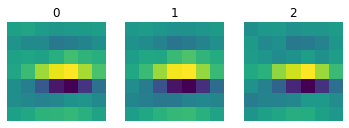

In [84]:
# plot old_weight
show_input_stage_weights(old_weight, nrows=1)

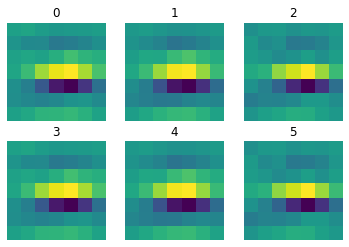

In [85]:
# plot new_weight
show_input_stage_weights(new_weight)

In [86]:
# replace first conv layer with a 6-channel version
efficientnet_f[0] = nn.Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [87]:
efficientnet_f[0]

Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [88]:
efficientnet_f[0].weight.shape

torch.Size([64, 6, 7, 7])

In [89]:
# set new_weights to nn.Parameter and overwrite it in the conv layer
efficientnet_f[0].weight = nn.Parameter(new_weight) # hand over requires_grad False?

In [90]:
# check if weight was loaded properly
assert torch.allclose(new_weight, efficientnet_f[0].weight)

In [91]:
efficientnet_f[0].weight.shape, efficientnet_f[0].weight.requires_grad

(torch.Size([64, 6, 7, 7]), True)

In [92]:
# network is in full train mode!
#[p.requires_grad for p in efficientnet_b3f.parameters()]

In [93]:
def set_rg(model=efficientnet_f, option=False):
    for param in model.parameters():
        param.requires_grad = option

In [94]:
# set requires grad for the efficientnet to false (to later only set it true for the input)
# WE WILL NOT DO THIS, because it should be not necessary!
set_rg()

In [95]:
# network is frozen
#[p.requires_grad for p in efficientnet_b4f.parameters()]

In [96]:
efficientnet_f[0].weight.requires_grad

False

In [97]:
# set input stage to trainable
#efficientnet_f._conv_stem.weight.requires_grad = True

In [98]:
#efficientnet_f._conv_stem.weight.requires_grad

In [99]:
efficientnet_f(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 1920, 4, 4])

## EfficientNet Pre-Head

In [100]:
def resnet_pre_head(concat_pool:bool=True):
    pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    layers = [pool, Flatten()]
    return nn.Sequential(*layers)

In [101]:
efficientnet_f_prehead = resnet_pre_head()

In [102]:
efficientnet_f_prehead

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Flatten()
)

In [103]:
efficientnet_f_prehead(torch.randn(2, 1920, 9, 9)).shape

torch.Size([2, 3840])

In [104]:
efficientnet_fph = nn.Sequential(efficientnet_f, efficientnet_f_prehead)

In [105]:
efficientnet_fph(torch.randn(1,6,sz,sz)).shape

torch.Size([1, 3840])

## CellType & Plate Group Feature Extractor

In [106]:
exps = len(set([exp2int[i] for i in exp2int])); exps

26

In [107]:
class CellTypePlateGroupFeatures(nn.Module):
    '''CellType Feature Extractor.'''
    def __init__(self, cell_types=4, plate_groups=4, exps=exps, emb_sz=128):
        super(CellTypePlateGroupFeatures, self).__init__()
        self.emb_ctint = nn.Embedding(cell_types, emb_sz)
        self.emb_pgint = nn.Embedding(plate_groups, emb_sz)
        self.emb_expint = nn.Embedding(exps, emb_sz)
        
    def forward(self, xb_ctint, xb_pgint, xb_expint, yb=None): # yb=None for training in non-AdaCos mode!
        
        ### CTINT
        # check if we are in CutMix mode:
        if isinstance(xb_ctint, tuple):
            x1, x2, λ = xb_ctint
            out1 = self.emb_ctint(x1)
            out2 = self.emb_ctint(x2)
            out_ctint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_ctint = self.emb_ctint(xb_ctint)
        
        ## PGINT
        # check if we are in CutMix mode:
        if isinstance(xb_pgint, tuple):
            x1, x2, λ = xb_pgint
            out1 = self.emb_pgint(x1)
            out2 = self.emb_pgint(x2)
            out_pgint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_pgint = self.emb_pgint(xb_pgint)
            
        ## EXPINT
        # check if we are in CutMix mode:
        if isinstance(xb_expint, tuple):
            x1, x2, λ = xb_expint
            out1 = self.emb_expint(x1)
            out2 = self.emb_expint(x2)
            out_expint = out1 * λ + out2 * (1-λ)
        else: # if not CutMix, then normal mode
            out_expint = self.emb_expint(xb_expint)
        
        out = torch.cat((out_ctint, out_pgint,  out_expint), dim=-1)
        
        return out

In [108]:
ctf = CellTypePlateGroupFeatures()

In [109]:
ctf

CellTypePlateGroupFeatures(
  (emb_ctint): Embedding(4, 128)
  (emb_pgint): Embedding(4, 128)
  (emb_expint): Embedding(26, 128)
)

In [110]:
xb = (torch.tensor(ct2int['HEPG2']),
      torch.tensor(fn2pgint['train/HEPG2-01/Plate1/B03_s1']),
      torch.tensor(exp2int['train/HEPG2-01/Plate1/B03_s1'.split('/')[1]])
     )

In [111]:
xb

(tensor(0), tensor(0), tensor(0))

In [112]:
ctf(xb[0], xb[1], xb[2]).shape

torch.Size([384])

In [113]:
xb = (torch.tensor((1,3)), torch.tensor((1,3)), torch.tensor((1,3)))

In [114]:
xb

(tensor([1, 3]), tensor([1, 3]), tensor([1, 3]))

In [115]:
ctf(xb[0], xb[1], xb[2]).shape

torch.Size([2, 384])

In [116]:
ct2int['HEPG2'], ct2int['RPE']

(0, 2)

In [117]:
fn2pgint['train/HEPG2-01/Plate1/B03_s1'], fn2pgint['train/RPE-01/Plate1/B03_s1']

(0, 0)

In [118]:
exp2int['HEPG2-01'], exp2int['RPE-01']

(0, 19)

In [119]:
xb = ((torch.tensor(ct2int['HEPG2']), torch.tensor(ct2int['RPE']), 0.9),
      (torch.tensor(fn2pgint['train/HEPG2-01/Plate1/B03_s1']),
       torch.tensor(fn2pgint['train/RPE-01/Plate1/B03_s1']), 0.9),
      (torch.tensor(exp2int['HEPG2-01']),
       torch.tensor(exp2int['RPE-01']), 0.9))

In [120]:
ctf(xb[0], xb[1], xb[2]).shape

torch.Size([384])

In [121]:
#class CellTypeFeatures(nn.Module):
#    '''CellType Feature Extractor.'''
#    def __init__(self, cell_types=4, emb_sz=128, lin_ftrs:Optional[Collection[int]]=None, nc=128):
#        super(AdaCosNet, self).__init__()
#        self.emb = nn.Embedding(cell_types, emb_sz)
#        
#        self.lin_ftrs = [emb_sz, 512, 512] if lin_ftrs is None else [emb_sz] + lin_ftrs + [nc]
#
#        
#    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
#
#        return out

## AdaCos-Head

In [122]:
def create_adacos_head(nf:int, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                bn_final:bool=False): # concat_pool:bool=True, nc:int,
    "Model head that takes `nf` features, runs through `lin_ftrs`, and about `nc` classes."
    
    # ADDED TWO MORE 512 LAYERS !!!
    lin_ftrs = [nf, 512, 512, 512, 512] if lin_ftrs is None else [nf] + lin_ftrs + [nc]
    # remove last 512 fc layer to reduce MODEL SIZE ??? ???
    
    ps = listify(ps)
    if len(ps) == 1: ps = [ps[0]/2] * (len(lin_ftrs)-2) + ps
    actns = [nn.ReLU(inplace=True)] * (len(lin_ftrs)-2) + [None]
    #pool = AdaptiveConcatPool2d() if concat_pool else nn.AdaptiveAvgPool2d(1)
    #layers = [pool, Flatten()]
    layers = []
    for ni,no,p,actn in zip(lin_ftrs[:-1], lin_ftrs[1:], ps, actns):
        layers += bn_drop_lin(ni, no, True, p, actn)
    if bn_final: layers.append(nn.BatchNorm1d(lin_ftrs[-1], momentum=0.01))
    #layers.append(AdaCos(lin_ftrs[-1], nc))
    return nn.Sequential(*layers)

In [123]:
#adacos_head = create_adacos_head(nf=2048+1) 
adacos_head = create_adacos_head(nf=1920*2+128*3)
# se_xresnet50f: 2048*2=4096, ctf: 128*3

In [124]:
adacos_head

Sequential(
  (0): BatchNorm1d(4224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=4224, out_features=512, bias=True)
  (3): ReLU(inplace)
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.25)
  (6): Linear(in_features=512, out_features=512, bias=True)
  (7): ReLU(inplace)
  (8): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.25)
  (10): Linear(in_features=512, out_features=512, bias=True)
  (11): ReLU(inplace)
  (12): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): Dropout(p=0.5)
  (14): Linear(in_features=512, out_features=512, bias=True)
)

In [125]:
#adacos_head

In [126]:
adacos_head(torch.randn(2, 1920*2+128*3)).shape

torch.Size([2, 512])

In [127]:
# from https://github.com/4uiiurz1/pytorch-adacos/blob/master/metrics.py
class AdaCos(nn.Module):
    def __init__(self, num_features, num_classes, m=0.50):
        super(AdaCos, self).__init__()
        self.num_features = num_features
        self.n_classes = num_classes
        self.s = math.sqrt(2) * math.log(num_classes - 1)
        self.m = m
        self.W = nn.Parameter(torch.FloatTensor(num_classes, num_features))
        nn.init.xavier_uniform_(self.W)

    def forward(self, xb, yb):
        
        #print(yb.shape)
        #pdb.set_trace()
        
        # normalize features
        x = F.normalize(xb)
        # normalize weights
        W = F.normalize(self.W)
        # dot product
        logits = F.linear(x, W)
        
        # for training in non-AdaCos mode (= no yb date in the forward pass):
        if yb is None:
            print('yb = None')
            return logits
        
        # feature re-scale
        theta = torch.acos(torch.clamp(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        one_hot = torch.zeros_like(logits)
        
        # ORIGINAL
        #one_hot.scatter_(1, yb.view(-1, 1).long(), 1)
        #with torch.no_grad():
        #    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
        #    B_avg = torch.sum(B_avg) / xb.size(0)
        #    #print(B_avg)
        #    theta_med = torch.median(theta[one_hot == 1])
        #    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        #    #print(self.s)
            
        # ADAPTED FOR CUTMIX TO GET MIXED SCALE PARAMETER
        with torch.no_grad():
            # FROM nb_new_data_augmentation_adacos2.py LINE 888
            # AND https://github.com/fastai/fastai/blob/master/fastai/callbacks/mixup.py#L40
            if yb.ndim == 2:# and target.shape[-1] >1:
                n_mod_patches = (yb.shape[-1] - 1) // 2
                #c_ = yb[:, 1:n_mod_patches + 1]
                c_ = yb[:, 0:n_mod_patches + 1]
                W_ = yb[:, n_mod_patches + 1:]
                self.s_scaled = []
                
                # this loop is only realdy needed when we have different probabilities inside a batch
                # which we do not have (right now)! So this could be cleaned up, but we leave until
                # we know we will not need the case with different probabilities in a batch.
                for k in range(n_mod_patches+1):
                    yb_new = c_[:, k].long()
                    #pdb.set_trace()
                    
                    one_hot.scatter_(1, yb_new.view(-1,1).long(), 1)
                    
                    B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                    B_avg = torch.sum(B_avg) / xb.size(0)
                    theta_med = torch.median(theta[one_hot == 1])
                    self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
                    
                    if k+1 == len(range(n_mod_patches+1)):
                        #self.s_scaled.append((1-W_[:, k-1]) * self.s)
                        self.s_scaled.append((1-W_[0, k-1]) * self.s)
                        # For more than two the sum of W_[:, :k] has to be used!!!
                    else:
                        #self.s_scaled.append(W_[:, k] * self.s)
                        self.s_scaled.append(W_[0, k] * self.s)
                    # Mixed B_avg & self.s and single are not really far off, but now we have it coded
                    # se we keep it (until it breaks something later).
                self.s = torch.add(*self.s_scaled)
                # Clean up, self.s_scaled is just a vector with the same entry multiple times
                # when it is not indexed above with W_[0,... !
            else:
                one_hot.scatter_(1, yb.view(-1,1).long(), 1)
                B_avg = torch.where(one_hot < 1, torch.exp(self.s * logits), torch.zeros_like(logits))
                B_avg = torch.sum(B_avg) / xb.size(0)
                theta_med = torch.median(theta[one_hot == 1])
                self.s = torch.log(B_avg) / torch.cos(torch.min(math.pi/4 * torch.ones_like(theta_med), theta_med))
        
        output = self.s * logits

        return output

## Network

In [128]:
class AdaCosNet(nn.Module):
    '''Simple AdaCosNet connecter to run xb through the feature extractor head
    and then feed xb and yb into the AdaCos layer.'''
    def __init__(self, body1, body2, head):
        super(AdaCosNet, self).__init__()
        self.body1 = body1
        self.body2 = body2
        self.head = head
        self.adacos = AdaCos(512, 1108)
        
    def forward(self, xb, yb=None): # yb=None for training in non-AdaCos mode!
        xb_img, xb_ctint, xb_pgint, xb_expint = xb
        resnet_features = self.body1(xb_img)
        int_features = self.body2(xb_ctint, xb_pgint, xb_expint)
        features = torch.cat((resnet_features, int_features), dim=-1)
        out = self.head(features)
        #print('xb.shape: ', xb.shape,', yb.shape: ', yb.shape)
        out = self.adacos(out, yb)
        #print('out: ',out.shape)
        #pdb.set_trace()
        return out

In [129]:
adacos_efficientnet = AdaCosNet(efficientnet_fph, ctf, adacos_head)

In [130]:
xb = (torch.randn(2,6,sz,sz),
      #(torch.randint(4, (2,1)),  torch.randint(4, (2,1)))
      torch.tensor((1,3)), torch.tensor((1,3)), torch.tensor((1,3))
     )

In [131]:
adacos_efficientnet(xb).shape

yb = None


torch.Size([2, 1108])

In [132]:
adacos_efficientnet(xb, torch.tensor([513, 1])).shape

torch.Size([2, 1108])

In [133]:
test_target = torch.tensor(
    [[2.4700e+02, 3.3900e+02, 7.8362e-01],
     [2.3300e+02, 7.7400e+02, 7.8362e-01],
     [7.7400e+02, 1.3400e+02, 7.8362e-01],
     [6.9800e+02, 8.4700e+02, 7.8362e-01]])

In [134]:
adacos_efficientnet((torch.randn(4,6,sz,sz), 
                     torch.tensor((1,3,0,2)), torch.tensor((1,3,0,2)), torch.tensor((1,3,0,2))),
                    test_target).shape

torch.Size([4, 1108])

In [135]:
# Based on https://forums.fast.ai/t/teacher-forcing/29415/4
# https://forums.fast.ai/t/on-batch-begin-callback/35201/3
@dataclass
class AppendBatchTargs(Callback):
    learn:Learner
    def __init__(self, learn):
        super().__init__()
    def on_batch_begin(self, last_input, last_target, **kwargs):
        return {'last_input':(last_input, last_target), 'last_target':last_target}

In [136]:
#batch = next(iter(data.train_dl))

In [137]:
#batch

In [138]:
#batch[0][0].shape, batch[0][1].shape, batch[0][2].shape

In [139]:
#batch[0][1]

In [140]:
#batch[0][2]

In [141]:
#adacos_se_xresnet50c.cuda()

In [142]:
#adacos_se_xresnet50c(batch[0]).shape

# Training

## EfficientNet

In [143]:
learn = Learner(data, adacos_efficientnet, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [144]:
#xxx

In [145]:
# generate layer groups for discriminative layer training
# https://docs.fast.ai/basic_train.html#Discriminative-layer-training
#learn.split((adacos_efficientnet_b4.body1[0]._conv_stem,
#             #adacos_efficientnet_b3.body._blocks, # all blocks as a layer group
#             *[adacos_efficientnet_b4.body1[0]._blocks[i] for i in range(31)], # put in each block
#             adacos_efficientnet_b4.body1[0]._conv_head,
#             adacos_efficientnet_b4.head,
#             adacos_efficientnet_b4.adacos
#            ));

In [146]:
# https://github.com/pytorch/pytorch/issues/7455
#class LabelSmoothingLoss(nn.Module):
#    def __init__(self, classes, smoothing=0.0, dim=-1):
#        super(LabelSmoothingLoss, self).__init__()
#        self.confidence = 1.0 - smoothing
#        self.smoothing = smoothing
#        self.cls = classes
#        self.dim = dim
#
#    def forward(self, pred, target):
#        pred = pred.log_softmax(dim=self.dim)
#        with torch.no_grad():
#            # true_dist = pred.data.clone()
#            true_dist = torch.zeros_like(pred)
#            true_dist.fill_(self.smoothing / (self.cls - 1))
#            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
#        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [147]:
#labsmooth_loss = LabelSmoothingLoss(1108, 0.1)

In [148]:
#input = torch.randn(3, 5, requires_grad=True)
#target = torch.empty(3, dtype=torch.long).random_(5)
#labsmooth_loss(input, target)

In [149]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [150]:
#learn.loss_func = labsmooth_loss
#learn.loss_func

In [151]:
learn.opt_func

functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99))

In [152]:
# https://docs.fast.ai/callbacks.fp16.html
#learn.to_fp16(loss_scale=512, clip=1e3);

In [153]:
# Make Adam FP16 proof:
# https://forums.fast.ai/t/mixed-precision-training/29601/21
# https://discuss.pytorch.org/t/adam-half-precision-nans/1765
# https://vxlabs.com/2019/02/04/improving-fastais-mixed-precision-support-with-nvidias-automatic-mixed-precision/
#learn.opt_func = partial(learn.opt_func, eps=1e-4)
#learn.opt_func
#
### ADD CLIP PARAMETER TOO???

In [154]:
#learn.layer_groups

In [155]:
def check_rg(model=learn.model):
    layer_rg = [(n, p.requires_grad) for n,p in model.named_parameters()]
    for i in range(len(layer_rg)):
        print(f'{layer_rg[i][0]}\t{layer_rg[i][1]}'.expandtabs(50))

In [156]:
# unfreeze network
#learn.unfreeze()
#set_rg(learn.model.body, option=True)

In [157]:
check_rg() # check where trainable

body1.0.conv0.weight                              False
body1.0.norm0.weight                              False
body1.0.norm0.bias                                False
body1.0.denseblock1.denselayer1.norm1.weight      False
body1.0.denseblock1.denselayer1.norm1.bias        False
body1.0.denseblock1.denselayer1.conv1.weight      False
body1.0.denseblock1.denselayer1.norm2.weight      False
body1.0.denseblock1.denselayer1.norm2.bias        False
body1.0.denseblock1.denselayer1.conv2.weight      False
body1.0.denseblock1.denselayer2.norm1.weight      False
body1.0.denseblock1.denselayer2.norm1.bias        False
body1.0.denseblock1.denselayer2.conv1.weight      False
body1.0.denseblock1.denselayer2.norm2.weight      False
body1.0.denseblock1.denselayer2.norm2.bias        False
body1.0.denseblock1.denselayer2.conv2.weight      False
body1.0.denseblock1.denselayer3.norm1.weight      False
body1.0.denseblock1.denselayer3.norm1.bias        False
body1.0.denseblock1.denselayer3.conv1.weight    

In [158]:
#learn.summary()

### Pretraining

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 4.79E-03


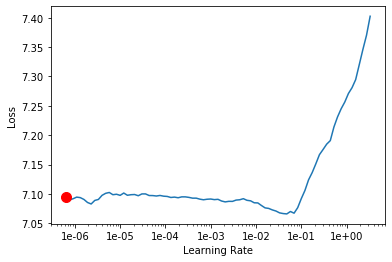

In [159]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [160]:
learn.fit_one_cycle(60, max_lr=1e-2, pct_start=0.2, final_div=1e3)

epoch,train_loss,valid_loss,accuracy,time
0,5.541075,5.558274,0.008982,06:29
1,5.358150,5.471547,0.015379,06:34
2,5.272576,5.395871,0.018545,06:28
3,5.141720,5.325679,0.023456,06:30
4,5.069848,5.228136,0.029788,06:33
5,4.999183,5.182996,0.032179,06:33
6,4.934362,5.067384,0.036831,06:28
7,4.884365,5.081416,0.035474,06:31
8,4.821100,5.032394,0.040967,06:33
9,4.819016,4.990979,0.047622,06:31


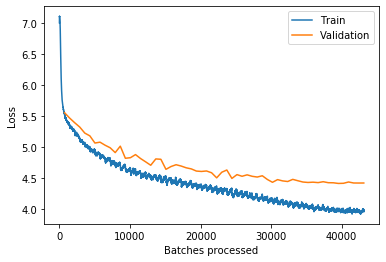

In [161]:
learn.recorder.plot_losses()

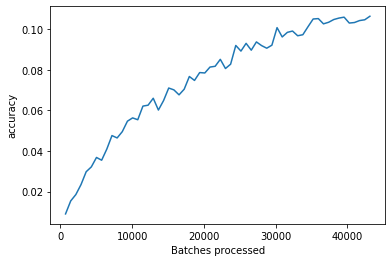

In [162]:
learn.recorder.plot_metrics()

In [163]:
learn.save('densenet/adacos_densenet201_pg_exp_Pre060_190830')

In [164]:
learn.load('densenet/adacos_densenet201_pg_exp_Pre060_190830');

In [165]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-07


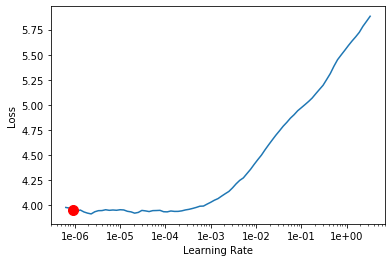

In [166]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [167]:
learn.fit_one_cycle(200, max_lr=1e-3, pct_start=0.2, final_div=1e3)

epoch,train_loss,valid_loss,accuracy,time
0,3.856701,4.346076,0.109977,07:02
1,3.779825,4.259509,0.124645,07:01
2,3.734406,4.174027,0.135565,07:00
3,3.702168,4.215472,0.128005,07:01
4,3.676842,4.150388,0.142479,07:00
5,3.676460,4.278695,0.134531,06:59
6,3.645540,4.309387,0.120897,07:00
7,3.662374,4.221450,0.130654,07:00
8,3.626679,4.277308,0.125162,07:00
9,3.626804,4.304784,0.115728,07:02


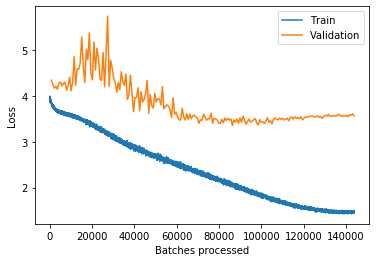

In [168]:
learn.recorder.plot_losses()

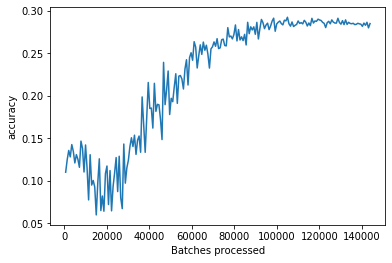

In [169]:
learn.recorder.plot_metrics()

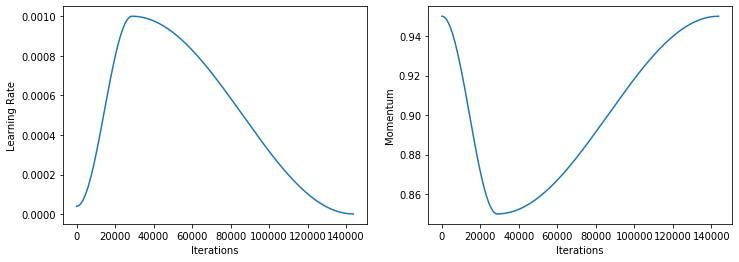

In [170]:
learn.recorder.plot_lr(show_moms=True)

In [171]:
learn.save('densenet/adacos_densenet201_pg_exp_Pre060e200_190830')

In [172]:
learn.load('densenet/adacos_densenet201_pg_exp_Pre060e200_190830');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 6.31E-08


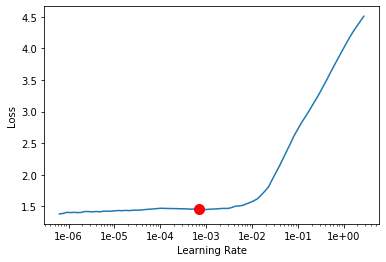

In [173]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Train #1

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060_190822');

In [ ]:
learn.fit_one_cycle(1, max_lr=1e-3)

In [ ]:
check_rg() # check where trainable

In [ ]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e001_190823')

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e001_190823');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e001-085_190823_best')

In [ ]:
learn.fit_one_cycle(84, max_lr=1e-3, pct_start=0.2, final_div=1e3, callbacks=[savem])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e001-085_190823_best');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Train #2

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e001-085_190823_best');

In [ ]:
learn.unfreeze()

In [ ]:
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e005-50_190823_best')

In [ ]:
learn.fit_one_cycle(45, max_lr=1e-4, callbacks=[savem])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823')

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### CutMix Training (NOT WORKING)

In [ ]:
learn = Learner(data, adacos_efficientnet, metrics=[accuracy],
                callback_fns=[CSVLogger, AppendBatchTargs])#.to_fp16()

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823');

In [ ]:
learn.unfreeze()

In [ ]:
learn.cutmix();

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(60, max_lr=1e-4)

In [ ]:
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e060-CM060_190824_best')

In [ ]:
learn.fit_one_cycle(59, max_lr=1e-4, callbacks=[savem])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
#learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050CM012_190824')

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050CM012_190824');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Train #3 CutOut (NOT WORKING)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823');

In [ ]:
learn.unfreeze()

In [ ]:
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050CU000-050_190824_best')

In [ ]:
learn.fit_one_cycle(50, max_lr=1e-4,
                    pct_start=0.2, final_div=1000,
                    callbacks=[savem])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050CU017_190824')

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050CU017_190824');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Train #4 ReduceLR (NOT WORKING)

In [ ]:
learn.unfreeze()

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823');

In [ ]:
check_rg() # check where trainable

In [ ]:
redlr = ReduceLROnPlateauCallback(learn, monitor='accuracy', patience=4)
savem = SaveModelCallback(learn, every='improvement', monitor='accuracy', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050RLR000-035_190824_best')

In [ ]:
learn.fit(35, lr=1e-5, callbacks=[savem, redlr])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050RLR035_190824')

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050RLR035_190824');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Train #5 Full

In [ ]:
learn.unfreeze()

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050_190823');

In [ ]:
check_rg() # check where trainable

In [ ]:
savem = SaveModelCallback(learn, every='improvement', monitor='train_loss', 
                          name='effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050Full000-045_190825_best')

In [ ]:
learn.fit_one_cycle(45, max_lr=1e-4, callbacks=[savem])

In [ ]:
learn.recorder.plot_losses()

In [ ]:
#learn.recorder.plot_metrics()

In [ ]:
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.save('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050Full045_190825')

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050Full045_190825');

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

### Custom Blend CutMix

In [ ]:
from nb_new_data_augmentation_adacos_celltype_plategroup_exp_blend import *

In [ ]:
kwargs = {
    'size': .05, 
    'alpha': .2,
    'blend_type': 'zero', 
}

In [ ]:
learn.blend(**kwargs);

In [ ]:
learn.fit_one_cycle(1, 1e-3)

In [ ]:
%debug

In [ ]:
# Define transform function
tfm_fn = partial(blend, blend_type='cut', same_size=False)

#Define schedule parameters
sch_param=['size', 'fixed_proba']
sch_val = [(.05, 2), .2 ]  # You can also enter a list of tuples
sch_iter = [(0., .3), (0., .7)]  # And a tuple with start and end iteration percentage
sch_func = [annealing_cos, partial(cosine_annealing, pct_start=.3)] # options: None = annealing_linear, annealing_cos, cosine_annealing
plot = True
test = True  # if True this will stop training in the first mini-batch
sch_tfm_cb = partial(TfmScheduler, tfm_fn=tfm_fn, sch_param=sch_param, sch_val=sch_val, 
                      sch_iter=sch_iter, sch_func=sch_func, plot=plot, test=test)
learn.callback_fns.append(sch_tfm_cb)

# Submission

## Classifcation

In [ ]:
learn.load('resnet50/adacos_se_xresnet50c_val-split-v2_128e040-256e106CMe110_20190729');

In [ ]:
# get prediction of test dataset
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
# check length
len(preds)

In [ ]:
# get the categories
preds_cat = preds.argmax(dim=-1)

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_cat})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with the same/not the same the prediction for both sites
idx = [] # indices with the same prediction
idx_notsame = [] # indices with not the same prediction
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    if i % 2:
        # distance from row 2 is 
        if pred == r[1]['sirna']:
            idx.append(r[0])
        else:
            #idx.append(r[0]) # always append idx until we come up with something better
            idx.append(idx_row_before)
            idx_notsame.append(idx_row_before) # get the first rows of the pairs that are not the same
    else:
        # save dist from row 1 for comparison in next iteration
        pred = r[1]['sirna']
        idx_row_before = r[0]

In [ ]:
len(idx), len(idx_notsame)

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_e080CM112_190805'
model = 'metriclearn_efficientnet_b3_e080CM112_190805'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


## Cosinus similarity

### Full single features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
# extended tfms
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75, 
                      xtra_tfms=[color_augmentation()])

# crop_pad: https://forums.fast.ai/t/misc-issues/35386/10

In [ ]:
# extended tfms w/o color_augmentation !!!
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_rotate=90.0, max_zoom=1.1, 
                      max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75)

In [ ]:
# change "crop_pad" from get_transforms to "crop"
# CENTER for FIXED cropping
tfms[0][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])
tfms[1][0] = crop(size=sz, row_pct=[0.5,0.5], col_pct=[0.5,0.5])

In [ ]:
# train crop
tfms[0][0].kwargs['row_pct'], tfms[0][0].kwargs['col_pct']

In [ ]:
# valid crop
tfms[1][0].kwargs['row_pct'], tfms[1][0].kwargs['col_pct']

In [ ]:
#sz, bs = 300, 8*2*2 # 3436MiB /  7952MiB
#sz, bs = 300, 8*8 # 6884MiB /  7952MiB
sz, bs = 300, 8*11 # 7938MiB /  7952MiB

In [ ]:
# VALID SPLIT (incl. tfms)
data = (ImageList6Dct.from_df(df_train, path='train')
        #.split_from_df(col=-1) # split_by_rand_pct()
        .split_none()
        .label_from_df(cols=-3)
        .add_test(ImageList6Dct.from_df(df_test, path='test'))
        .transform(tfms, size=sz) # remove size so we get the crop size!
        .databunch(bs=bs))

In [ ]:
data.normalize([stats_mean, stats_var]);

In [ ]:
#data.train_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.train_ds)
#data.train_dl.dl.batch_sampler.drop_last = False
#
#data.valid_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.valid_ds)
#data.valid_dl.dl.batch_sampler.drop_last = False
#
## DOES WORK TOO FOR TEST DL ??? ??? (Or do we need to set the test dataset to the valid dataset?)
#data.test_dl.dl.batch_sampler.sampler = torch.utils.data.SequentialSampler(data.test_ds)
#data.test_dl.dl.batch_sampler.drop_last = False

In [ ]:
learn = Learner(data, adacos_efficientnet)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050Full045_190825');

In [ ]:
#def get_feats(model, dataloader, cycles=1):
#    feats = []
#    targs = []
#    model.eval()
#    with torch.no_grad():
#        for i in range(cycles): # for TTA
#            for xb, yb in dataloader:
#                body_out = model.body(xb)
#                head_out = model.head(body_out)
#                feats.append(head_out.cpu())
#                targs.append(yb.cpu())
#    return feats, targs

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                xb_img, xb_ctint, xb_pgint, xb_expint = xb
                resnet_features = model.body1(xb_img)
                int_features = model.body2(xb_ctint, xb_pgint, xb_expint)
                features = torch.cat((resnet_features, int_features), dim=-1)
                out = model.head(features)
                feats.append(out.cpu())
                targs.append(yb.cpu())
    return feats, targs

#### Train

In [ ]:
feats, targs = get_feats(learn.model, learn.data.train_dl, cycles=3)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, targs.shape

In [ ]:
np.save('pred/feats_train.npy', feats)
np.save('pred/targs_train.npy', targs)

#### Valid

In [ ]:
feats, targs = get_feats(learn.model, learn.data.valid_dl)

In [ ]:
feats = torch.cat(feats, dim=0)
targs = torch.cat(targs, dim=0)

In [ ]:
feats.shape, feats.shape, targs.shape

In [ ]:
np.save('pred/feats_valid.npy', feats)
np.save('pred/targs_valid.npy', targs)

#### Test

In [ ]:
feats, targs = get_feats(learn.model, learn.data.test_dl)

In [ ]:
del targs

In [ ]:
feats = torch.cat(feats, dim=0)

In [ ]:
feats.shape

In [ ]:
np.save('pred/feats_test.npy', feats)

### Multi-crop features

In [ ]:
# https://github.com/ducha-aiki/whale-identification-2018/blob/master/reproduce_problems.ipynb
# And for test-time augmentation I used following random solution: switch train and val transforms

In [ ]:
df_train['test'] = 0
df_train['path'] = 'train/'+df_train['path']

In [ ]:
df_train.head()

In [ ]:
# add dummy columns for test dataset
df_test['path'] = 'test/'+df_test['path']
df_test['test'] = 1
df_test['sirna'] = 1

In [ ]:
df_test.head()

In [ ]:
df_train_test = pd.concat((df_train, df_test), axis=0, sort=False)

In [ ]:
df_train_test.tail()

In [ ]:
# reload for train and valid ds
df_train = pd.read_csv('full_train_dataset_valid-split-ex_v2_20190727.csv', index_col=0)
df_test = pd.read_csv('full_test_dataset_v2_20190727.csv', index_col=0)

In [ ]:
# test tfms switching for test ds
#tfms_switched = (tfms[1], tfms[0])
#
#data = (ImageList6D.from_df(df_train_test, path='.')
#                .split_from_df(col=-1)
#                .label_from_df(cols=-4)
#                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#                .databunch(bs=bs))

In [ ]:
#data.train_ds[0][0]

In [ ]:
#data.valid_ds[0][0]

In [ ]:
def get_dataset(row_pct, col_pct, is_test=False):
    # extended tfms
    tfms = get_transforms(do_flip=True, flip_vert=True, 
                          max_rotate=90.0, max_zoom=1.1, 
                          max_lighting=0.2, max_warp=0.2, 
                          p_affine=0.75, p_lighting=0.75, 
                          xtra_tfms=[color_augmentation()])
    
    # change "crop_pad" from get_transforms to "crop"
    tfms[0][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    tfms[1][0] = crop(size=sz, row_pct=row_pct, col_pct=col_pct)
    
    # VALID SPLIT (incl. tfms)
    if is_test:
        #switch train with valid (= test) tfms!
        tfms_switched = (tfms[1], tfms[0])
        
        data = (ImageList6D.from_df(df_train_test, path='.')
                .split_from_df(col=-1)
                .label_from_df(cols=-4)
                .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    else:
        data = (ImageList6D.from_df(df_train, path='train')
                .split_from_df(col=-1) # split_by_rand_pct()
                .label_from_df(cols=-3)
                #.add_test(ImageList6D.from_df(df_test, path='test'))
                .transform(tfms)#, size=sz) # remove size so we get the crop size!
                .databunch(bs=bs))
    
    data.normalize([tensor([0.0456, 0.0702, 0.0447, 0.0468, 0.0407, 0.0399]),
                    tensor([0.0644, 0.0733, 0.0536, 0.0633, 0.0555, 0.0392])]);
    
    return data

In [ ]:
def get_feats(model, dataloader, cycles=1):
    feats = []
    targs = []
    model.eval()
    with torch.no_grad():
        for i in range(cycles): # for TTA
            for xb, yb in dataloader:
                body_out = model.body(xb)
                head_out = model.head(body_out)
                feats.append(head_out.cpu())
                targs.append(yb.cpu())
                
    feats = torch.cat(feats, dim=0)
    targs = torch.cat(targs, dim=0)
    
    return feats, targs

In [ ]:
def save_feats(feats, targs, crop, ds='train'):
    np.save(f'pred/feats_{ds}_crop{crop}.npy', feats)
    np.save(f'pred/targs_{ds}_crop{crop}.npy', targs)

In [ ]:
#https://docs.fast.ai/vision.transform.html#_crop
crop_pos = [[0.,0.], [0.,1.],[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
# get random crop pos
i = 2
crop_pos = [[uniform(0,1), uniform(0,1)] for i in range(2)]

In [ ]:
crop_pos

In [ ]:
# get the last three crop positions:
crop_pos = [[0.5,0.5],[1.,0.], [1.,1.]]

In [ ]:
def get_crop_feats(model=learn.model, cycles=1, crop_pos=crop_pos):
    
    for i, (row_pct, col_pct) in enumerate(crop_pos):
        
        print('== crop#:', i,' of', len(crop_pos), '==')
        print('row_pct:', row_pct,', col_pct:', col_pct)
    
        data = get_dataset(row_pct, col_pct)
        
        # train
        print('= Start train dataset =')
        feats, targs = get_feats(model, data.train_dl)
        save_feats(feats, targs, i, ds='train')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish train dataset -')
        
        # valid
        print('= Start valid dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='valid')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish valid dataset -')
        
        # get test ds as valid ds for TTA
        data = get_dataset(row_pct, col_pct, is_test=True)
        
        # test
        print('= Start test dataset =')
        feats, targs = get_feats(model, data.valid_dl)
        save_feats(feats, targs, i, ds='test')
        print('feats:', feats.shape,' targs:', targs.shape)
        print('- Finish test dataset -')

In [ ]:
learn = Learner(data, adacos_efficientnet_b3)

In [ ]:
learn.load('effnet/adacos_efficientnet_b3_e080CM112_190805');

In [ ]:
get_crop_feats()

In [ ]:
#data = (ImageList6D.from_df(df_train_test, path='.')
#        .split_from_df(col=-1)
#        .label_from_df(cols=-4)
#        .transform(tfms_switched)#, size=sz) # remove size so we get the crop size!
#        .databunch(bs=bs))

### Submission

In [ ]:
# get the names
preds_names = learn.data.test_ds.x.items

In [ ]:
# without site
#preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3][:3] for x in preds_names]

# with site
preds_names = [x.split('/')[1]+'_'+x.split('/')[2][-1]+'_'+x.split('/')[3] for x in preds_names]

In [ ]:
preds_test = np.load('pred/preds_test.npy')
dist_test = np.load('pred/dist_test.npy')

In [ ]:
len(preds_names), len(preds_test), len(dist_test)

In [ ]:
#preds_test

In [ ]:
#dist_test

In [ ]:
df_preds = pd.DataFrame({'id_code_site': preds_names, 'sirna': preds_test, 'cossim': dist_test})

In [ ]:
# get id_code without site
df_preds['id_code'] = df_preds['id_code_site'].apply(lambda x: x[:-3])

In [ ]:
# get row indices with highest cosine similiarity
idx = []
for i, r in enumerate(df_preds.sort_values('id_code').iterrows()):
    #print(r)
    #print('i: ',i)
    #print('idx: ',r[0])
    #print(r[1]['cossim'])
    if i % 2:
        # distance from row 2 is 
        if dist < r[1]['cossim']:
            idx.append(r[0])
        else:
            idx.append(idx_row_before)
    else:
        # save dist from row 1 for comparison in next iteration
        dist = r[1]['cossim']
        idx_row_before = r[0]

In [ ]:
idx[:5]

In [ ]:
df_preds.sort_values('id_code').head(10)

In [ ]:
#df_preds.loc[idx,['id_code','sirna']]

In [ ]:
# 'effnet/adacos_efficientnet_b3_ct_pg_exp_Pre060e050Full045_190825'
model = 'metriclearn_efficientnet_b3_ct_pg_exp_Pre060e050Full045_190825_3xTTA-cossim'

In [ ]:
df_preds.loc[idx,['id_code','sirna']].to_csv('sub/'+model+'.csv.gz', index=False, compression='gzip')

In [ ]:
!kaggle competitions submit -c recursion-cellular-image-classification -f sub/{model}.csv.gz -m "{model}"


# Error analysis

In [ ]:
preds_correct = np.load('preds_valid_correct.npy')

In [ ]:
df_erros = pd.DataFrame({'id_code': preds_names, 'correct': preds_test})

In [ ]:
df_erros[df_errors['correct'] == False]

In [ ]:
# ERROR ANALYSIS !!!